In [10]:
from langchain.text_splitter import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf
from pprint import pprint
import fitz
import tesserocr
from PIL import Image
import re
from ollama import generate

In [59]:
%env EXTRACT_IMAGE_BLOCK_CROP_HORIZONTAL_PAD=100
%env EXTRACT_IMAGE_BLOCK_CROP_VERTICAL_PAD=100

env: EXTRACT_IMAGE_BLOCK_CROP_HORIZONTAL_PAD=100
env: EXTRACT_IMAGE_BLOCK_CROP_VERTICAL_PAD=100


In [ ]:
class Document:
    def __init__(self, title, content, metadata = {}, parent = None, level = 0):
        self.title = title
        self.content = content
        self.metadata = metadata
        self.parent = parent
        self.level = level
        self.children = []

    def add_child(self, child):
        self.children.append(child)

In [62]:
# Extract elements from PDF
def extract_pdf_elements(path, fname, image_path):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path to extract PDF documents
    fname: File name
    image_path: Path to save images
    """
    return partition_pdf(
        filename=path + fname,    
        strategy='hi_res',  
        infer_table_structure=True,
        # chunking_strategy="by_title",
        hi_res_model_name = 'detectron2_onnx', 
        extract_image_block_types=["Image", "Table","Figure"],
        extract_image_block_output_dir=image_path,
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
    )

In [ ]:
"""
Helps in determining the font size of the title
"""
pages = {}
doc = fitz.open("files/2022-annual-report-wf-trimmed.pdf")
api = tesserocr.PyTessBaseAPI(path="/usr/share/tesseract-ocr/5/tessdata")


def get_title_level(element):
    metadata = element.metadata

    # Load the page
    page_key = f"{metadata.filename}-{metadata.page_number}"
    if not page_key in pages:
        pages[page_key] = doc.load_page(metadata.page_number - 1)
    page = pages[page_key]

    # Get the image clip
    coords = metadata.coordinates.points
    pix = page.get_pixmap(dpi=200)
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples).crop(
        coords[0][0], coords[0][1], coords[2][0], coords[2][1]
    )

    api.SetImage(image)
    api.Recognize()
    iterator = api.GetIterator()
    attrs = iterator.WordFontAttributes()

    if attrs["pointsize"] < 20:
        return 4
    elif attrs["pointsize"] < 25:
        return 3
    elif attrs["pointsize"] < 30:
        return 2
    else:
        return 1

In [ ]:
def has_image_text(image_file_name):
    with open(image_file_name, "rb") as f:
        api.SetImage(f.read())
        api.Recognize()
        iterator = api.GetIterator()
        return len(iterator.GetUTF8Text()) > 0

In [ ]:
describe_prommpt = "You are an assistant tasked with summarizing tables and image for retrieval. \
    These summaries will be embedded and used to retrieve the raw table or image elements. \
    Give a concise summary of the table or image that is well optimized for retrieval:"


def get_image_description(image_file_name):
    with open(image_file_name, "rb") as f:
        image = f.read()
        response = generate(model="llava", prompt=describe_prommpt, images=[image], stream=False)
        return response["response"]

In [ ]:
def detect_text_in_image(raw_images):
    reader = easyocr.Reader(['en'],gpu=True)  # Create the OCR reader
    # Store the raw images where text was detected
    text_detected_images = {}

    for key, value in raw_images.items():
        text_detected_raw_images = []

        for image_bytes in value:
            results = reader.readtext(image_bytes,detail=0)
            if results:
                # Check the length of results, because there are certain images with hashtag
                # or no significant information
                if len(results) > 10:
                    text_detected_raw_images.append(image_bytes)
        # Add only those raw images of the page which would be used 
        # in Llava to describe the image  
        if len(text_detected_raw_images) > 0:            
            text_detected_images[key] = text_detected_raw_images
    
    return text_detected_images

prompt = """Describe the contents in the image. Follow the below guidelines while generating the description of the image.
1. Do not give the style or font details
2. Do not describe image if it does not contain important information
3. Do not start the description with "The image" or "This image". We know that it is an image,
so there is no need to explicitly mention it.
"""

def extract_image_description(text_detected_images):
    image_description = {}
    

    for key, value in text_detected_images.items():
        page_image_description = []
        
        for raw_image in value:
            response = generate(model = 'llava', prompt=prompt, images=[raw_image], stream=False)
            
            page_image_description.append(response['response'])

        if len(page_image_description) > 0:            
            image_description[key] = page_image_description

    return image_description  

In [79]:
for element in raw_pdf_elements:
    if element.category == 'Table':
        pprint(vars(element.metadata))

{'_known_field_names': frozenset({'attached_to_filename',
                                  'category_depth',
                                  'coordinates',
                                  'data_source',
                                  'detection_class_prob',
                                  'detection_origin',
                                  'emphasized_text_contents',
                                  'emphasized_text_tags',
                                  'file_directory',
                                  'filename',
                                  'filetype',
                                  'header_footer_type',
                                  'image_base64',
                                  'image_mime_type',
                                  'image_path',
                                  'is_continuation',
                                  'languages',
                                  'last_modified',
                                  'link_texts',
          

In [ ]:
top = Document("Wells Fargo", "")
parent = top

regex_roman_numeral = re.compile(r"^[IVXLCDMivxlcdm]+$")


def build_documents(elements):
    current_title = ""
    current_level = 0

    for element in elements:
        if element.category == 'Title' and element.text == '2022 Annual Report':
            # Ignore this as this is the footer text
            continue
        if element.category == 'ListItem' and (regex_roman_numeral.match(element.text) or element.text.isnumeric()):
            # Ignore this as this is the footer page number
            continue

        if element.category == 'Title':
            current_level = get_title_level(element)
            current_title = element.text
            if current_level == parent.level:
                parent = parent.parent
            elif current_level < parent.level:
                while current_level <= parent.level:
                    parent = parent.parent
        elif element.category == 'Text' or element.category == 'NarrativeText':
            parent.add_child(Document(current_title, element.text, element.metadata, parent, current_level))
        elif element.category == 'Table':
            text = get_image_description(element.metadata.filename)
            parent.add_child(Document(current_title, text, element.metadata, parent, current_level))
        elif element.category == 'Image' and has_image_text(element.metadata.filename):
            text = get_image_description(element.metadata.filename)
            parent.add_child(Document(current_title, text, element.metadata, parent, current_level))
        else:
            print('Ignored element', element.category)
            

In [63]:
# Process the Wf document
# File path
fpath = "files/"
fname = "2022-annual-report-wf-trimmed.pdf"
image_path = "data1"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname,image_path)

Sak detectron2_onnx


In [ ]:
# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables, texts, and images.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    images = []
    table_chunk = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
        elif "unstructured.documents.elements.Image" in str(type(element)):
            images.append(str(element))
        elif "unstructured.documents.elements.Table" in str(type(element)):
            table_chunk.append(str(element))

    return texts, tables, images

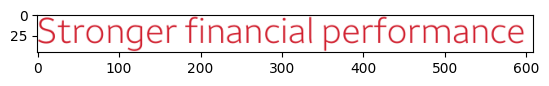

In [57]:
# Get title image using pymupdf

import fitz  # PyMuPDF
import matplotlib.pyplot as plt
from PIL import Image

doc = fitz.open('files/2022-annual-report-wf-trimmed.pdf')
page = doc.load_page(1)
page.get_text()

"""
116.66666666666666,
                                             779.1527777777777),
                                            (116.66666666666666,
                                             825.2332014738074),
                                            (726.3822222222225,
                                             825.2332014738074),
                                            (726.3822222222225,
                                             779.1527777777777
"""
pix = page.get_pixmap(dpi=200)
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples).crop((116.66666666666666, 779.1527777777777, 726.3822222222225, 825.2332014738074))
plt.imshow(image)
# image.width

In [58]:
import io
import tesserocr
from PIL import Image

path='/usr/share/tesseract-ocr/5/tessdata'
with tesserocr.PyTessBaseAPI(path=path) as api:
    api.SetImage(image)
    api.Recognize()  # required to get result from the next line
    iterator = api.GetIterator()
    print(iterator.WordFontAttributes())

{'font_name': '', 'bold': False, 'italic': False, 'underlined': False, 'monospace': False, 'serif': False, 'smallcaps': False, 'pointsize': 32, 'font_id': -1}


In [66]:
element.metadata.coordinates.points

((747.8611111111111, 2124.708333333333),
 (747.8611111111111, 2144.152777777778),
 (956.4611111111111, 2144.152777777778),
 (956.4611111111111, 2124.708333333333))

In [27]:
for element in raw_pdf_elements:
    if element.category == 'Title':
        print(element.text)
        
        pprint(vars(element.metadata))

Annual Report
{'_known_field_names': frozenset({'attached_to_filename',
                                  'category_depth',
                                  'coordinates',
                                  'data_source',
                                  'detection_class_prob',
                                  'detection_origin',
                                  'emphasized_text_contents',
                                  'emphasized_text_tags',
                                  'file_directory',
                                  'filename',
                                  'filetype',
                                  'header_footer_type',
                                  'image_base64',
                                  'image_mime_type',
                                  'image_path',
                                  'is_continuation',
                                  'languages',
                                  'last_modified',
                                  'link_text

In [8]:
# Get text, tables
texts, tables, images = categorize_elements(raw_pdf_elements)